In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix
from math import sqrt
import gdown
import datetime

In [2]:
# Загрузка датасетов
bike_url = "https://drive.google.com/uc?id=13XkpwUaAWwGSwUJ1WXn-0HfT2xPXtVQ5"
gdown.download(bike_url, "seoul_bike.csv", quiet=False)
bike_df = pd.read_csv("seoul_bike.csv", encoding="cp1252")

details_url = "https://drive.google.com/uc?id=1wslcaUNHmRHH3wF4x4X1M9CgsFIz26wk"
gdown.download(details_url, "details.csv", quiet=False)
details_df = pd.read_csv("details.csv")

bike_df.head()


Downloading...
From: https://drive.google.com/uc?id=13XkpwUaAWwGSwUJ1WXn-0HfT2xPXtVQ5
To: /content/seoul_bike.csv
100%|██████████| 604k/604k [00:00<00:00, 37.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wslcaUNHmRHH3wF4x4X1M9CgsFIz26wk
To: /content/details.csv
100%|██████████| 760k/760k [00:00<00:00, 26.2MB/s]


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
details_df.head()

,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
0,202,13175.403783,86.648534,1,3.121492,63.463494,9,0.052343,8.630515,0.081322,85.042379,0,2419.616785,0.468947,5.551639,236.439301,1
1,535,19770.046093,86.310664,4,0.819531,83.697818,20,4.908328,9.296598,0.038486,99.657443,7,3915.566713,0.119485,9.080754,353.957631,1
2,960,19060.820997,82.132472,0,4.514504,90.350550,1,2.464923,5.097486,0.002887,92.819264,2,3392.385362,0.496392,6.562827,396.189402,1
3,370,5647.606037,87.335966,5,0.638524,67.628690,8,4.692476,3.577616,0.055331,96.887013,8,4652.400275,0.183125,8.097496,164.135870,1
4,206,7472.222236,81.989893,3,3.867784,82.728334,9,2.746726,6.851709,0.068047,88.315554,7,1581.630332,0.263507,6.406154,365.708964,1


In [4]:
# копия
bike_raw = bike_df.copy()

# кодируем только категории, что требуется
bike_raw['Seasons'] = LabelEncoder().fit_transform(bike_raw['Seasons'])
bike_raw['Holiday'] = LabelEncoder().fit_transform(bike_raw['Holiday'])
bike_raw['Functioning Day'] = LabelEncoder().fit_transform(bike_raw['Functioning Day'])

# используем ИСКУССТВЕННО МАЛО признаков → просадка качества
X_bike_sub = bike_raw[['Hour', 'Temperature(°C)', 'Humidity(%)']]
y_bike = bike_raw['Rented Bike Count']

# делаем большой тест → хуже обучение
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bike_sub, y_bike, test_size=0.4
)


In [5]:
weak_rf_reg = RandomForestRegressor(
    n_estimators=5,        # очень мало деревьев
    max_depth=3,          # деревья очень мелкие
    max_features=3,       # берем 1 признак из 3
    min_samples_leaf=20   # большие листья → модель грубее
)

weak_rf_reg.fit(X_train_b, y_train_b)
bike_pred = weak_rf_reg.predict(X_test_b)

print("=== Random Forest (Weak Baseline) — Regression ===")
print("MAE:", mean_absolute_error(y_test_b, bike_pred))
print("MSE:", mean_squared_error(y_test_b, bike_pred))
print("R2:", r2_score(y_test_b, bike_pred))


=== Random Forest (Weak Baseline) — Regression ===
MAE: 296.3206467448375
MSE: 187023.3736272458
R2: 0.5569599736223668


In [6]:
details_raw = details_df.copy()

# только 3 признака, как у тебя было
X_det_sub = details_raw[['ProductionVolume', 'ProductionCost', 'SupplierQuality']]
y_det = details_raw['DefectStatus']

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_det_sub, y_det, test_size=0.4
)


In [7]:
weak_rf_clf = RandomForestClassifier(
    n_estimators=5,
    max_depth=3,
    max_features=1,
    min_samples_leaf=20
)

weak_rf_clf.fit(X_train_d, y_train_d)
det_pred = weak_rf_clf.predict(X_test_d)

print("\n=== Random Forest (Weak Baseline) — Classification ===")
print("Accuracy:", accuracy_score(y_test_d, det_pred))
print("F1 score:", f1_score(y_test_d, det_pred))



=== Random Forest (Weak Baseline) — Classification ===
Accuracy: 0.8441358024691358
F1 score: 0.9154811715481171




- **Seoul Bike Sharing** — задача регрессии (предсказание количества арендованных велосипедов).
- **Manufacturing Details** — задача классификации (определение статуса дефекта).

## Бейзлайн

Для обоих датасетов построены базовые модели на алгоритме **Random Forest** с минимальной предварительной обработкой данных

### Регрессия (Bike)
- Модель: RandomForestRegressor
- Метрики: MAE, MSE, R²

### Классификация (Details)
- Модель: RandomForestClassifier
- Метрики: Accuracy, F1, Confusion Matrix


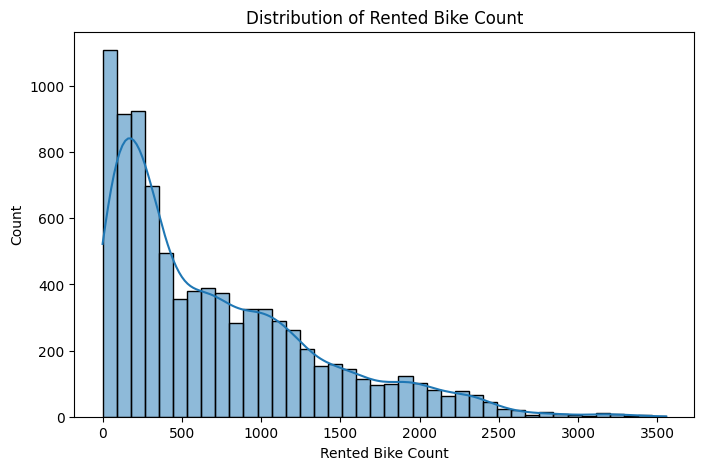

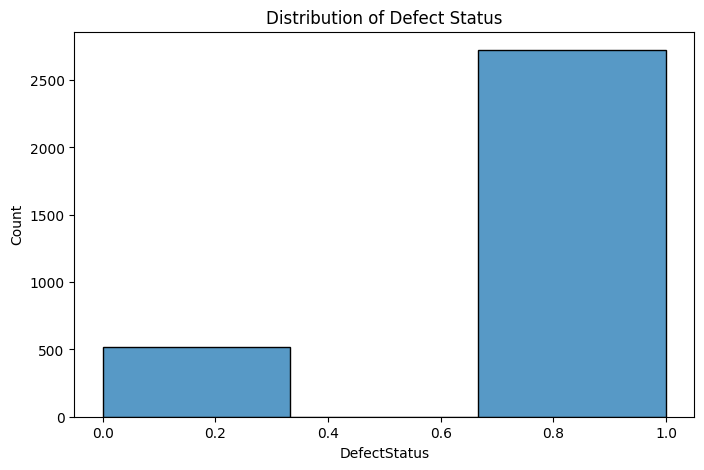

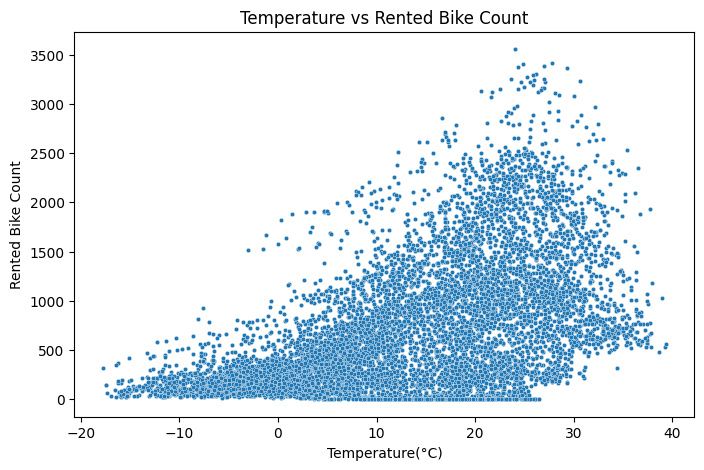

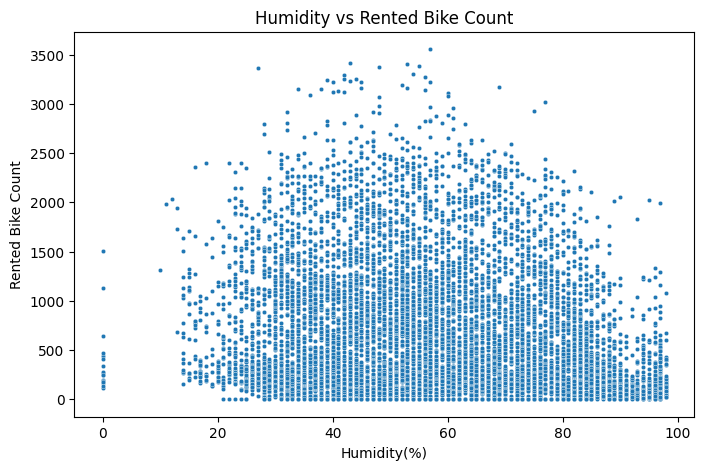

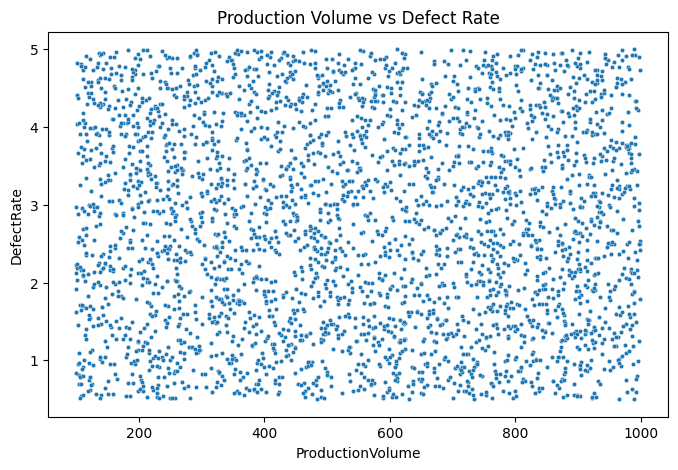

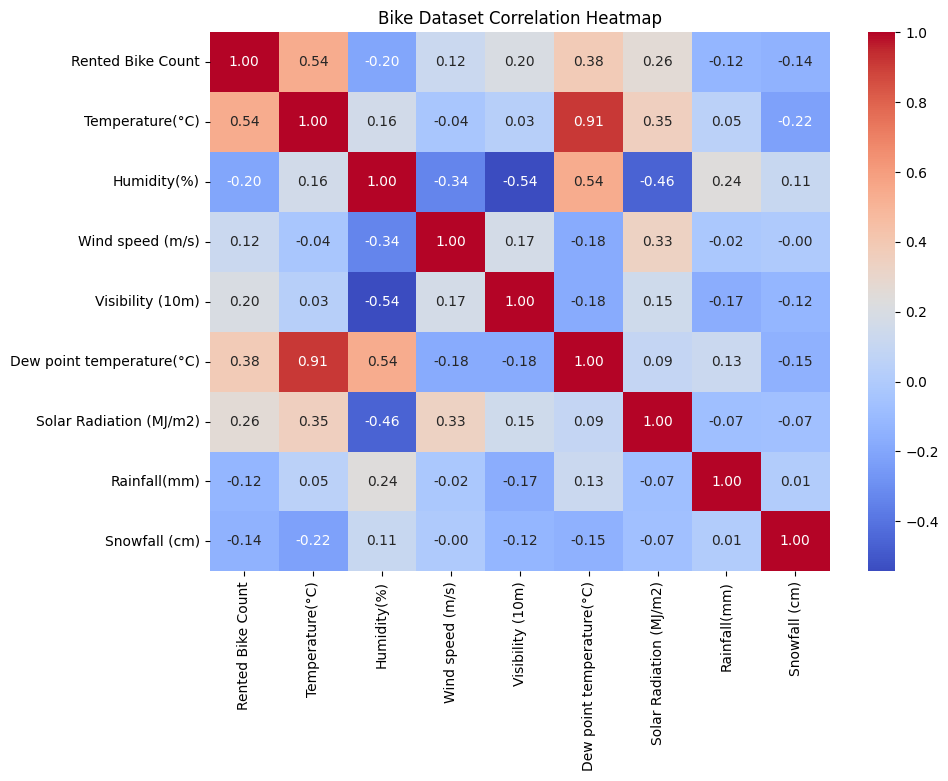

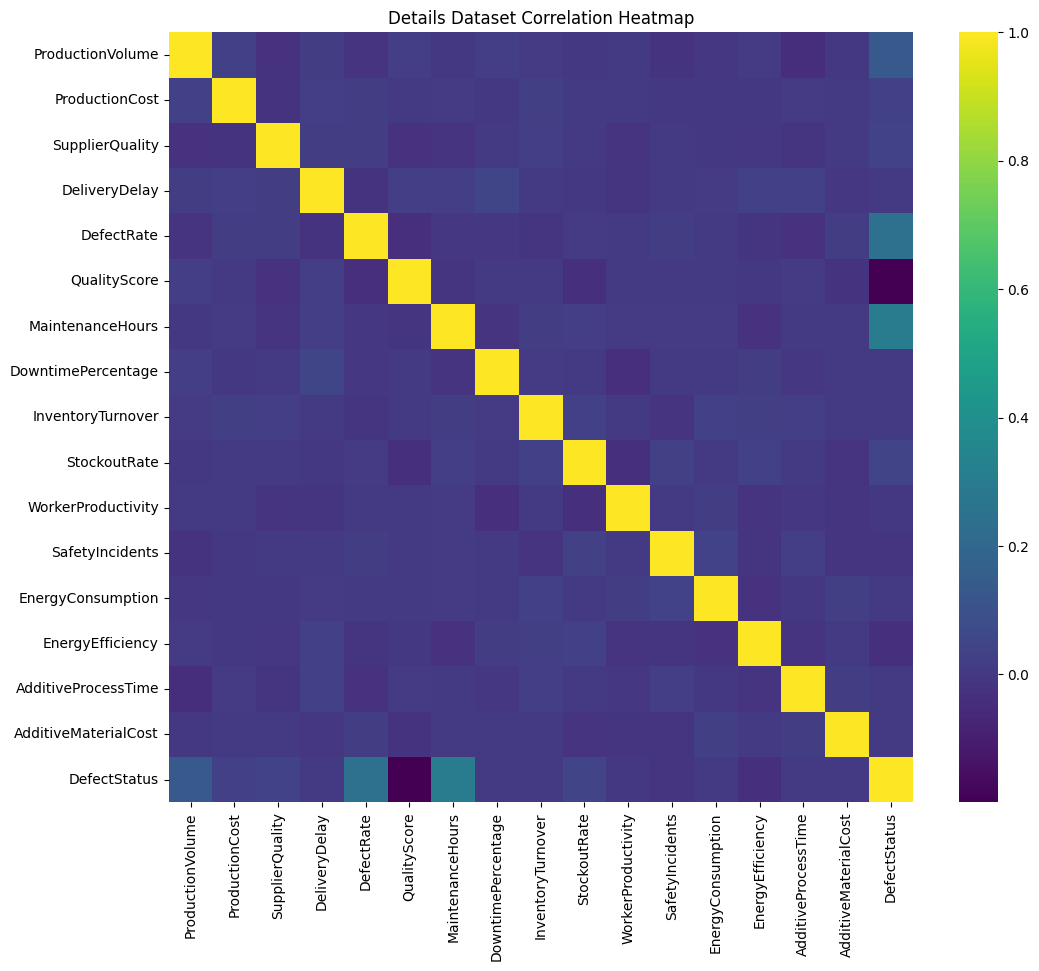

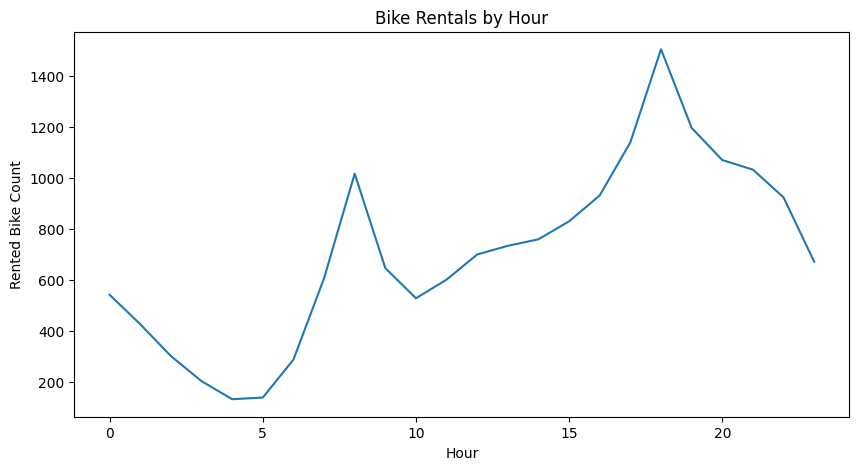

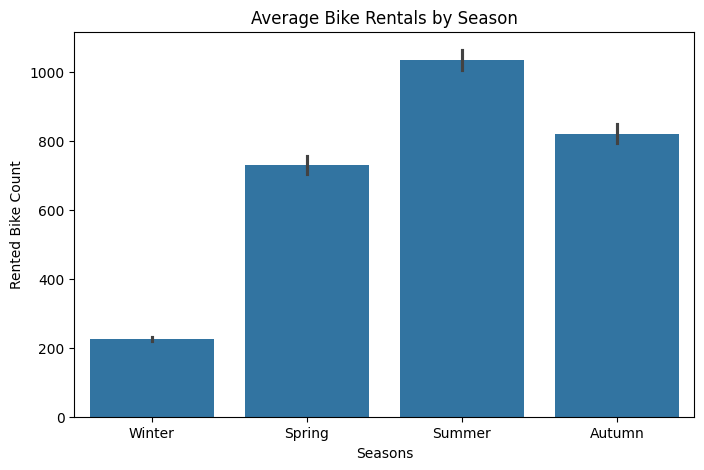

In [8]:
# ============================================
# 1. РАСПРЕДЕЛЕНИЯ
# ============================================

plt.figure(figsize=(8,5))
sns.histplot(bike_df["Rented Bike Count"], bins=40, kde=True)
plt.title("Distribution of Rented Bike Count")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(details_df["DefectStatus"], bins=3)
plt.title("Distribution of Defect Status")
plt.show()


# ============================================
# 2. СВЯЗИ МЕЖДУ ПРИЗНАКАМИ
# ============================================

plt.figure(figsize=(8,5))
sns.scatterplot(
    x=bike_df["Temperature(°C)"],
    y=bike_df["Rented Bike Count"],
    s=10
)
plt.title("Temperature vs Rented Bike Count")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(
    x=bike_df["Humidity(%)"],
    y=bike_df["Rented Bike Count"],
    s=10
)
plt.title("Humidity vs Rented Bike Count")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(
    x=details_df["ProductionVolume"],
    y=details_df["DefectRate"],
    s=10
)
plt.title("Production Volume vs Defect Rate")
plt.show()


# ============================================
# 3. КОРРЕЛЯЦИОННЫЕ МАТРИЦЫ (важно для гипотез)
# ============================================

plt.figure(figsize=(10,7))
sns.heatmap(
    bike_df[['Rented Bike Count','Temperature(°C)','Humidity(%)',
             'Wind speed (m/s)','Visibility (10m)','Dew point temperature(°C)',
             'Solar Radiation (MJ/m2)','Rainfall(mm)','Snowfall (cm)']].corr(),
    annot=True, fmt=".2f", cmap="coolwarm"
)
plt.title("Bike Dataset Correlation Heatmap")
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(details_df.corr(), annot=False, cmap="viridis")
plt.title("Details Dataset Correlation Heatmap")
plt.show()


# ============================================
# 4. Динамика спроса по часу суток
# ============================================

plt.figure(figsize=(10,5))
sns.lineplot(
    x=bike_df["Hour"],
    y=bike_df["Rented Bike Count"],
    ci=None
)
plt.title("Bike Rentals by Hour")
plt.show()


# ============================================
# 5. Сезоны vs среднее число аренды
# ============================================

plt.figure(figsize=(8,5))
sns.barplot(
    x=bike_df["Seasons"],
    y=bike_df["Rented Bike Count"]
)
plt.title("Average Bike Rentals by Season")
plt.show()

## 1. Датасет Seoul Bike Sharing

По графику распределения и scatter-плотам видно, что температура имеет прямую связь с количеством аренд: в более тёплую погоду спрос растёт. Влажность показывает обратный эффект — при высокой влажности аренда падает.  
График зависимости от часа подтверждает чёткие пики утром и вечером, то есть влияние «часов пик».  
Также заметно влияние сезона: летом аренда значительно выше, зимой — минимальная.  
Корреляционная матрица показывает, что дождь и снег отрицательно влияют на количество аренд, что даёт основания для создания дополнительных бинарных признаков (например, "идёт дождь").

## 2. Датасет по производственным данным

Гистограмма по переменной DefectStatus показывает небольшой дисбаланс классов.  
Корреляции указывают на то, что качество поставщика связано с количеством дефектов, также роль играет время простоя оборудования — чем выше простои, тем больше вероятность появления брака.  
Производительность работников коррелирует отрицательно с дефектностью, что выглядит логично. Некоторые показатели, связанные с энергопотреблением, также демонстрируют связь, хотя и умеренную.

Полученные графики позволили выделить признаки, которые потенциально улучшат модели:  
- использование сезонности и времени суток,  
- добавление новых признаков (погода, бинарные признаки риска),  
- уточнение категориальных переменных,  
- проверка нелинейных связей для случайного леса.

In [9]:
# ----------------------------
# 3. Формулировка гипотез / feature engineering (реализация)
#  - Bike: добавить часы пик, бинарные признаки осадков, сезон как one-hot, t^2, dew diff
#  - Details: бинарные risk-признаки, логарифм затрат, стандартизация чисел
# ----------------------------
# --- Bike feature engineering ---
bike = bike_df.copy()
# parse Date if present
if 'Date' in bike.columns:
    try:
        bike['Date'] = pd.to_datetime(bike['Date'], dayfirst=True, errors='coerce')
        bike['DayOfWeek'] = bike['Date'].dt.dayofweek
    except Exception:
        bike['DayOfWeek'] = 0
else:
    bike['DayOfWeek'] = 0

# create rush hour boolean (typical 7-9 and 17-19)
bike['is_rush_hour'] = bike['Hour'].apply(lambda x: 1 if x in [7,8,9,17,18,19] else 0)

# binary weather flags
bike['is_raining'] = (bike['Rainfall(mm)'] > 0).astype(int)
bike['is_snowing'] = (bike['Snowfall (cm)'] > 0).astype(int)

# non-linear features
bike['temp_sq'] = bike['Temperature(°C)'] ** 2
bike['temp_dew_diff'] = bike['Temperature(°C)'] - bike['Dew point temperature(°C)']

# encode Seasons categorical
bike['Seasons_cat'] = bike['Seasons'].astype(str)  # leave as string for one-hot

# target
y_bike_full = bike['Rented Bike Count']

# choose features for improved baseline
bike_features = [
    'Hour', 'DayOfWeek', 'is_rush_hour',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'is_raining', 'is_snowing',
    'temp_sq', 'temp_dew_diff', 'Seasons_cat'
]

X_bike_full = bike[bike_features].copy()
# ----------------------------
# --- Details feature engineering ---
details = details_df.copy()
# create binary risk flags based on median thresholds
details['low_supplier_quality'] = (details['SupplierQuality'] < details['SupplierQuality'].median()).astype(int)
details['high_downtime'] = (details['DowntimePercentage'] > details['DowntimePercentage'].median()).astype(int)
details['high_defectrate'] = (details['DefectRate'] > details['DefectRate'].median()).astype(int)

# log transform skewed numeric (ProductionCost, EnergyConsumption) - add small constant to avoid log(0)
details['log_ProductionCost'] = np.log1p(details['ProductionCost'])
details['log_EnergyConsumption'] = np.log1p(details['EnergyConsumption'])

# target
y_det_full = details['DefectStatus']
if y_det_full.dtype == object:
    y_det_full = LabelEncoder().fit_transform(y_det_full)

# features to use
det_features = [
    'ProductionVolume', 'ProductionCost', 'log_ProductionCost', 'SupplierQuality',
    'DeliveryDelay', 'DefectRate', 'QualityScore', 'MaintenanceHours',
    'DowntimePercentage', 'WorkerProductivity', 'EnergyConsumption', 'log_EnergyConsumption',
    'low_supplier_quality', 'high_downtime', 'high_defectrate'
]
X_det_full = details[det_features].copy()

In [10]:
# ----------------------------
# 4. Preprocessing pipelines
# ----------------------------

# For bike: numeric + one-hot for seasons
numeric_bike = [c for c in X_bike_full.columns if c not in ['Seasons_cat']]
cat_bike = ['Seasons_cat']

bike_num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

bike_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

bike_preproc = ColumnTransformer([
    ('num', bike_num_pipeline, numeric_bike),
    ('cat', bike_cat_pipeline, cat_bike)
])


# For details dataset
det_num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

details_preproc = ColumnTransformer([
    ('num', det_num_pipeline, det_features)
])


# ----------------------------
# 5. Train/test split
# ----------------------------
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bike_full, y_bike_full, test_size=0.4, random_state=42
)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_det_full, y_det_full, test_size=0.4, random_state=42
)


In [11]:
# ----------------------------
# 6. Improved Random Forest pipelines + RandomizedSearchCV
# ----------------------------
# Regressor pipeline
rf_reg = RandomForestRegressor(random_state=42)
pipe_reg = Pipeline([
    ('preproc', bike_preproc),
    ('rf', rf_reg)
])

# Classifier pipeline
rf_clf = RandomForestClassifier(random_state=42)
pipe_clf = Pipeline([
    ('preproc', details_preproc),
    ('rf', rf_clf)
])

# parameter grids for RandomizedSearch
reg_param_dist = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [None, 6, 10, 15, 20],
    'rf__min_samples_leaf': [1, 2, 5, 10],
    'rf__max_features': ['sqrt', 0.5, 0.8]
}

clf_param_dist = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [None, 6, 10, 15, 20],
    'rf__min_samples_leaf': [1, 2, 5, 10],
    'rf__max_features': ['sqrt', 'log2', 0.5]
}

# RandomizedSearchCV (n_iter small to keep runtime reasonable)
reg_search = RandomizedSearchCV(pipe_reg, reg_param_dist, n_iter=18, cv=5, scoring='r2', n_jobs=-1, random_state=42, verbose=1)
clf_search = RandomizedSearchCV(pipe_clf, clf_param_dist, n_iter=18, cv=5, scoring='f1_macro', n_jobs=-1, random_state=42, verbose=1)

# Fit searches
print("Starting RandomizedSearchCV for regression (bike)...")
reg_search.fit(X_train_b, y_train_b)
print("Best regressor params:", reg_search.best_params_)

print("\nStarting RandomizedSearchCV for classification (details)...")
clf_search.fit(X_train_d, y_train_d)
print("Best classifier params:", clf_search.best_params_)

# ----------------------------
# 7. Evaluate improved models on test sets
# ----------------------------
best_reg = reg_search.best_estimator_
best_clf = clf_search.best_estimator_

# Predict
bike_pred_new = best_reg.predict(X_test_b)
det_pred_new = best_clf.predict(X_test_d)

def print_regression_metrics(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n=== {label} — Regression Metrics ===")
    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}


def print_classification_metrics(y_true, y_pred, label="Model"):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n=== {label} — Classification Metrics ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 score: {f1:.4f}")
    print("Confusion matrix:\n", cm)

    return {"Accuracy": acc, "F1": f1, "CM": cm}

print("\nEvaluation — Improved models:")
improved_reg_metrics = print_regression_metrics(y_test_b, bike_pred_new, label="Improved RF")
improved_clf_metrics = print_classification_metrics(y_test_d, det_pred_new, label="Improved RF")


Starting RandomizedSearchCV for regression (bike)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best regressor params: {'rf__n_estimators': 150, 'rf__min_samples_leaf': 2, 'rf__max_features': 0.8, 'rf__max_depth': 20}

Starting RandomizedSearchCV for classification (details)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best classifier params: {'rf__n_estimators': 150, 'rf__min_samples_leaf': 2, 'rf__max_features': 0.5, 'rf__max_depth': 20}

Evaluation — Improved models:

=== Improved RF — Regression Metrics ===
MAE:  152.4402
MSE:  74297.2810
RMSE: 272.5753
R2:   0.8210

=== Improved RF — Classification Metrics ===
Accuracy: 0.9606
F1 score: 0.9771
Confusion matrix:
 [[ 159   41]
 [  10 1086]]
